# Technical specifications
- The code can be executed with python 2.7 or higher.
- To run the notbook please intall pandas, numpy, scikit-learn, seaborn and matplotib.

# Preprocessing

## Read the data using Pandas

In [1]:
import pandas as pd

workloads_df = pd.read_csv("game_workload.csv")
injuries_df = pd.read_csv("injuries.csv")

# I pivoted the metric data to create a colum for each metric
metrics_df = pd.read_csv("metrics.csv")\
                .pivot_table(index=['athlete_id', 'date'], columns='metric', values='value')\
                .reset_index(level=['athlete_id', 'date'])

### Check if there is any null value
The data is complete, there is no empty values.

In [2]:
print(workloads_df.isnull().values.any())
print(injuries_df.isnull().values.any())
print(metrics_df.isnull().values.any())

False
False
False


## Quick description of the values of workloads and metrics

- This step allows to check the distribution of the values quickly.
- From the table it looks like the values are normally distributed.
- This will be confirmed when we visualise the data in the following cells.

In [3]:
display(workloads_df[['game_workload']].describe())
display(metrics_df[['groin_squeeze','hip_mobility']].describe())

,game_workload
count,2400.000000
mean,400.481667
std,47.991824
min,225.000000
25%,368.000000
50%,400.000000
75%,433.250000
max,534.000000


metric,groin_squeeze,hip_mobility
count,21900.000000,21900.000000
mean,209.998584,39.950091
std,93.281506,9.991810
min,-108.000000,-1.000000
25%,139.000000,33.000000
50%,213.000000,40.000000
75%,283.000000,47.000000
max,487.000000,83.000000


## Visualisation of the data to check if there is clear outlayers

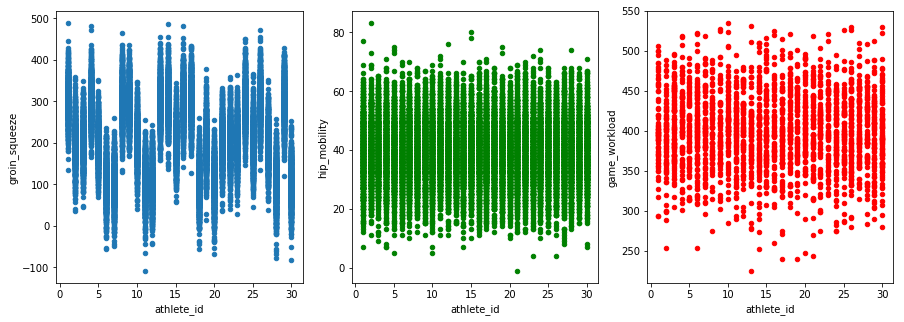

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(5)
fig.set_figwidth(15)

metrics_df[['athlete_id', 'groin_squeeze']]\
            .plot(x='athlete_id', y='groin_squeeze', kind="scatter", ax=axes[0])

metrics_df[['athlete_id', 'hip_mobility']]\
            .plot(x='athlete_id', y='hip_mobility', kind="scatter", ax=axes[1], color='green')

workloads_df[['athlete_id', 'game_workload']]\
            .plot(x='athlete_id', y='game_workload', kind="scatter", ax=axes[2], color='red')

### Discussion
- When visualising the data per athlete, no sign of outlayers.
- Some athletes have unusually low workload in some games, this is understandable as they may play for short time. **But more investigation can be done here**
- The metrics of each athlete tend to be normally distributed around a central value with some low and high tails.

**Let's visalise the frequencial distribution of the values**

Text(0,0.5,'freqency')

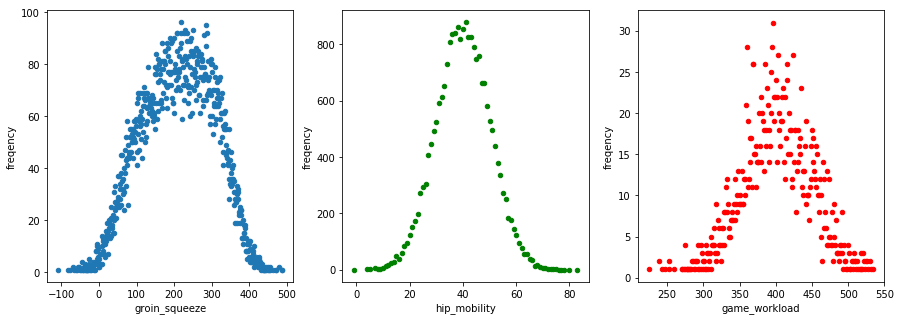

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(5)
fig.set_figwidth(15)

metrics_df.groupby('groin_squeeze')[['athlete_id']].agg(['count']).sort_values(by=['groin_squeeze'])\
             .reset_index().plot(x='groin_squeeze', y='athlete_id', kind="scatter", ax=axes[0])\
            .set_ylabel("freqency")

metrics_df.groupby('hip_mobility')[['athlete_id']].agg(['count']).sort_values(by=['hip_mobility'])\
             .reset_index().plot(x='hip_mobility', y='athlete_id', kind="scatter", ax=axes[1], color='green')\
            .set_ylabel("freqency")


workloads_df.groupby('game_workload')[['athlete_id']].agg(['count']).sort_values(by=['game_workload'])\
             .reset_index().plot(x='game_workload', y='athlete_id', kind="scatter", ax=axes[2], color='red')\
            .set_ylabel("freqency")

### Discussion

- The values of the two metrics and the games workloads are normally (or near-normally) distributed.
- Some workloads tend to occure more frequently than others and they lie in the centre of the workload graph (in the middle).
- The data looks ok, and there is no obvious outlayers.

**Now after having an idea about the data, we can conduct an analysis to check if there is a correlation between the injuries and the value of the factors.
I will start first by analysing each factor individually then each pair of factors.**

# Merge the data convert the date from String to datetime objects

In [7]:
# Add a column to the injuries DataFrame to serve a ground-truth when merged later with the other DataFrames 
injuries_df['injured'] = 1

merged_df = metrics_df\
        .merge(workloads_df, how="outer", on=['athlete_id', 'date']).fillna(0)\
        .merge(injuries_df,  how="outer", on=['athlete_id', 'date']).fillna(0)\
        .sort_values(by=['athlete_id', 'date'])

merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df['game'] = merged_df['game_workload'] > 0

In [8]:
merged_df.head(15)

,athlete_id,date,groin_squeeze,hip_mobility,game_workload,injured,game
0,1,2016-05-01,297,36,0.0,0.0,False
1,1,2016-05-02,274,36,0.0,0.0,False
2,1,2016-05-03,291,56,0.0,0.0,False
3,1,2016-05-04,260,24,0.0,0.0,False
4,1,2016-05-05,284,35,402.0,0.0,True
5,1,2016-05-06,318,15,0.0,0.0,False
6,1,2016-05-07,359,51,0.0,0.0,False
7,1,2016-05-08,250,41,365.0,0.0,True
8,1,2016-05-09,240,34,0.0,0.0,False
9,1,2016-05-10,385,44,0.0,0.0,False


# Quantify the metrics and workloads into 10 bins

The quantification allows a better visibility in this case.

In [9]:
merged_df['hip_mobility_group'] = pd.cut(merged_df['hip_mobility'], bins=10, labels=False)
merged_df['groin_squeeze_group'] = pd.cut(merged_df['groin_squeeze'], bins=10, labels=False)
merged_df['game_workload_group'] = pd.cut(merged_df['game_workload'], bins=10, labels=False)

# Check the frequency of injuries per metric and per workload group

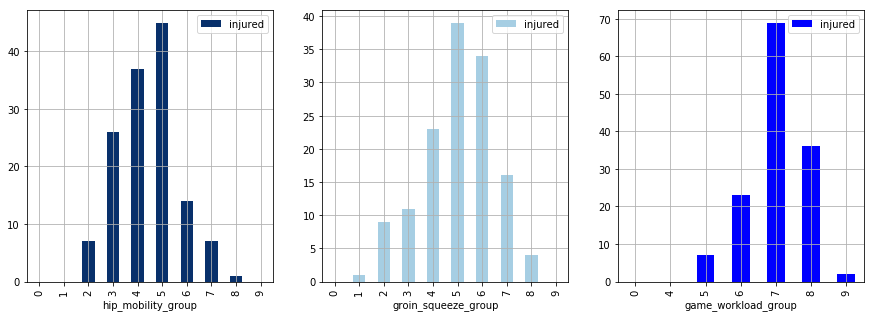

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(5)
fig.set_figwidth(15)

hip_mobilities_injury_corr = merged_df[['hip_mobility_group', 'injured']].groupby(['hip_mobility_group'], as_index=False).sum()
groin_squeeze_injury_corr = merged_df[['groin_squeeze_group', 'injured']].groupby(['groin_squeeze_group'], as_index=False).sum()
game_workload_injury_corr = merged_df[['game_workload_group', 'injured']].groupby(['game_workload_group'], as_index=False).sum()

hip_mobilities_injury_corr.plot(x='hip_mobility_group', y='injured', grid=True, ax=axes[0], kind='bar', colormap='Blues_r')
groin_squeeze_injury_corr.plot(x='groin_squeeze_group', y='injured', grid=True, ax=axes[1], kind='bar', colormap='Paired')
game_workload_injury_corr.plot(x='game_workload_group', y='injured', grid=True, ax=axes[2], kind='bar', colormap='winter')


### Discission
- The hip mobility graph shows a a normal distribution with a clear right tail, which means that in the cases of average and lower mobility, the players tend to suffer more injuries.
- The case is slightly opposite for the groin sqeeze graph, where the players suffer from injuries when the metric is around the average and higher.
- The workload-injuries correlation graph (on the right) is clearly biased to the high workloads.
- All graphes are close to normal distribution, but more investigation is needed to know why the tendency do not continue in one direction. One explanation can be that when the player has lower hip mobilitiy for example he will not be allowed to play the game thats why we don't see a high frequency of injuries when the hip mobility is very low. The same kind of exaplantion can be given for the other two graphs. **But more investigation can be done here**

**Now, we have checked if there is a correlation betwen each individual factor and the inuries. For a better understanding we can check the correlation between the injuries and pairs of factors**

# Check the correlation of injuries with each pair of factor

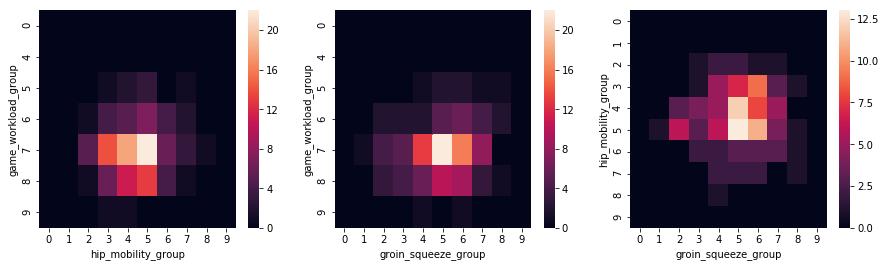

In [11]:
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(4)
fig.set_figwidth(15)


sns.heatmap(merged_df.groupby(['game_workload_group', 'hip_mobility_group'], as_index=False).sum()\
        .sort_values(by=['game_workload_group', 'hip_mobility_group'])\
        .pivot(index='game_workload_group', columns='hip_mobility_group', values='injured')\
        .fillna(0), ax=axes[0])

sns.heatmap(merged_df.groupby(['game_workload_group', 'groin_squeeze_group'], as_index=False).sum()\
        .sort_values(by=['game_workload_group', 'groin_squeeze_group'])\
        .pivot(index='game_workload_group', columns='groin_squeeze_group', values='injured')\
        .fillna(0), ax=axes[1])

sns.heatmap(merged_df.groupby(['hip_mobility_group', 'groin_squeeze_group'], as_index=False).sum()\
        .sort_values(by=['hip_mobility_group', 'groin_squeeze_group'])\
        .pivot(index='hip_mobility_group', columns='groin_squeeze_group', values='injured')\
        .fillna(0), ax=axes[2])

### Discssion
- The injuries tend to happen more when the hip mobility is average and a bit lower than average, and the workload is high but not extremely hight.
- For the groin sqeeze, when its value is average and a bit higher, and the workload is high (but not extremely hight), injuries happen more.
- When looking to the correlation btween the hip mobility and the groin squeeze, the injuries then to happen when both are average, and also when the hip mobility is low and the sqeeze is a bit higher than average.

# Analysing all factors together

- Normally, when the number of factors start to be high the data visualisation becomes more difficult/impossible.
- Machine Learning approaches are suitable to discover hidden patterns that are difficult to explore by human eye.
- For better performance, we usually add more features, so instead of relaying on only the raw values, I have calculated the average, maximum, minimum and standard deviation for the workload and metrics for each player in the 7 days preceeding any played game.
- When the player plays a game, and got injured the sample is considered as positive, and when he/she played a game without enjury the sample is considered as negative. So we can train a machine learning classifier to predict the likelyhood of injury knowing the past 7 days history of each player.
- The dataset is splitted between training and test where the training is the first 80% of the data (ordered by date) and the test is the remaining 20%.

#### Feature engineering step to calculate the average, maximum, minimum and standard deviations
Ideally, when more time is available, Deep Learning approaches can bypass the feature engineering

In [12]:
copy_merged_df = merged_df

merged_df['avg_hip_mob'] = copy_merged_df.groupby('athlete_id')['hip_mobility'].rolling(7).mean().to_frame().reset_index()['hip_mobility']
copy_merged_df = merged_df
merged_df['avg_groin_squeeze'] = copy_merged_df.groupby('athlete_id')['groin_squeeze'].rolling(7).mean().to_frame().reset_index()['groin_squeeze']


copy_merged_df = merged_df
merged_df['max_hip_mob'] = copy_merged_df.groupby('athlete_id')['hip_mobility'].rolling(7).max().to_frame().reset_index()['hip_mobility']

copy_merged_df = merged_df
merged_df['max_groin_squeeze'] = copy_merged_df.groupby('athlete_id')['groin_squeeze'].rolling(7).max().to_frame().reset_index()['groin_squeeze']

copy_merged_df = merged_df
merged_df['min_hip_mob'] = copy_merged_df.groupby('athlete_id')['hip_mobility'].rolling(7).min().to_frame().reset_index()['hip_mobility']

copy_merged_df = merged_df
merged_df['min_groin_squeeze'] = copy_merged_df.groupby('athlete_id')['groin_squeeze'].rolling(7).min().to_frame().reset_index()['groin_squeeze']

copy_merged_df = merged_df
merged_df['std_hip_mob'] = copy_merged_df.groupby('athlete_id')['hip_mobility'].rolling(7).std().to_frame().reset_index()['hip_mobility']

copy_merged_df = merged_df
merged_df['std_groin_squeeze'] = copy_merged_df.groupby('athlete_id')['groin_squeeze'].rolling(7).std().to_frame().reset_index()['groin_squeeze']

copy_merged_df = merged_df
merged_df['played_namges'] = copy_merged_df.groupby('athlete_id')['game'].rolling(7).sum().to_frame().reset_index()['game']

merged_df = merged_df.dropna()

#### Spltting the data into training and test sets

In [13]:
# Keep only the instances of played games, we are not interested in the days where the player did not played a gams.
filtered_workload_df = merged_df.loc[merged_df['game_workload'] >0]

# Create a list with the names of the columns that we want to use as features
columns = ['avg_hip_mob', 'avg_groin_squeeze', 'max_hip_mob', 'max_groin_squeeze',
           'min_hip_mob', 'min_groin_squeeze', 'std_hip_mob', 'std_groin_squeeze', 'played_namges',
          'groin_squeeze', 'hip_mobility']

# Split the data and the labels between train and test
dataset_size = filtered_workload_df['date'].count()
split_index = int(dataset_size*0.8)

train_features = filtered_workload_df[:split_index][columns]
test_features = filtered_workload_df[split_index:][columns]

train_y = filtered_workload_df[['injured']][:split_index]
test_y = filtered_workload_df[['injured']][split_index:]

#### Checking the number of positive and negative samples
- We notice that the dataset is imballanced, which is a very common phenomena in Machine Learning.
- The number of positive samples is much lower than the number of negative samples.
- When more time is available, some techniques could be used to avoid the negative effect of imballanced datasets.


In [14]:
train_positives = int(train_y.loc[train_y['injured']==1].count())
train_negatives = int(train_y.loc[train_y['injured']==0].count())

test_positives = int(test_y.loc[test_y['injured']==1].count())
test_negatives = int(test_y.loc[test_y['injured']==0].count())


print('Positive Samples in the training set: {}'.format(train_positives))
print('Negative Samples in the training set: {}'.format(train_negatives))
print('')
print('Positive Samples in the test set: {}'.format(test_positives))
print('Negative Samples in the test set: {}'.format(test_negatives))

Positive Samples in the training set: 109
Negative Samples in the training set: 1795

Positive Samples in the test set: 27
Negative Samples in the test set: 450


### Train a machine learning classifier (SVM)
- Other classification algoithms can be tested espcially ensembling like Random Forest or deep approaches like Nerual Netowrks.

In [15]:
from sklearn import svm

classifier = svm.LinearSVC(random_state=0)
classifier.fit(train_features, train_y['injured'])

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

In [16]:
from sklearn.metrics import average_precision_score
y_score = classifier.decision_function(test_features)
average_precision = average_precision_score(test_y['injured'], y_score)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.09


Text(0.5,1,'2-class Precision-Recall curve: AP=0.09')

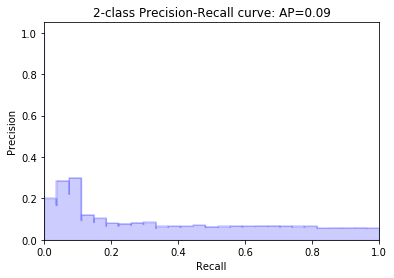

In [17]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(test_y['injured'], y_score)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

### Discussion

- The Average precision of the classifier on the test dataset is low which suggest a no clear correlation between the features and the injuries.
- The size of the dataset can be one of the main reasons behind the low performance. We need to gather more data, especially psitive samples.
- We can test other classification algorithms for better performance.
- However the higher precision at the low recal suggest that there are some pattern of correlation, we can look at these data to kow what are the values that led to this good prediction.
- With more time, more thourough exploratory data analytics can be done and more advanced Machine Learning algorithms can be used.
- Data like age, gender, ethnic origins can be very helpful in this case.
